# 0 - Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import wkt

from os.path import exists
from os import makedirs

from matplotlib.colors import Normalize, LogNorm
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable

import unicodedata


---

# 1 - Functions

## F1 - Data Lecture

In [2]:
def prepare_gdf(year, level = "Neighborhood"): # it reads the data and prepares the geodataframe with the rent per capita information for the neighborhoods of Barcelona

    # --- LOAD DATA ---

    data_dir = "../data/indicadores_socioeconomicos/"
    file = f"ist-14075-15023-mun_{year}.csv"

    df = pd.read_csv(data_dir + file, sep = ";", decimal = ",", engine = "python")

    # --- DATA SELECTION ---

    df_filtered = df[df["concepto"] == "renta media por persona (€)"] # filter for rent per capita
    df_selection = df_filtered[["barrios de Barcelona", "valor"]].copy() # select relevant columns

    # --- RENAME --- (in order to match with the geometry file)

    df_selection.rename(columns = {
        "barrios de Barcelona": "Neighborhood",
        "valor": "rent_per_capita"
    }, inplace = True)

    # --- DATA CLEANING ---

    df_selection["rent_per_capita"] = pd.to_numeric(df_selection["rent_per_capita"], errors = "coerce").fillna(0).astype(float) # convert to numeric, set errors to NaN, fill NaN with 0, convert to float
    df_selection["Neighborhood"] = df_selection["Neighborhood"].astype(str).str.strip().str.lower() # convert to string, strip whitespace, convert to lowercase
    df_selection["Neighborhood"] = df_selection["Neighborhood"].apply(lambda x: unicodedata.normalize("NFC", x)) # normalize unicode characters

    # ------------------------------------------------------------------------------------------------------------------------------------------

    # --- GEOMETRY FILE ---

    geometry_file = "../data/geometry/neighborhoods_geometry.csv"
    geometry_df = pd.read_csv(geometry_file)

    # --- RENAME --- (in order to match with the original dataset) (extra space in -)

    geometry_df["Neighborhood"] = geometry_df["Neighborhood"].replace("Sant Gervasi - la Bonanova", "Sant Gervasi-la Bonanova")
    geometry_df["Neighborhood"] = geometry_df["Neighborhood"].replace("Sant Gervasi - Galvany", "Sant Gervasi-Galvany")
    geometry_df["Neighborhood"] = geometry_df["Neighborhood"].replace("Sants - Badal", "Sants-Badal")
    geometry_df["Neighborhood"] = geometry_df["Neighborhood"].replace("el Poble-sec", "el Poble Sec")


    # --- DATA CLEANING --- 

    geometry_df["Geometry_etrs89"] = geometry_df["Geometry_etrs89"].apply(wkt.loads) # convert WKT to geometry
    geometry_df["Neighborhood"] = geometry_df["Neighborhood"].astype(str).str.strip().str.lower() # convert to string, strip whitespace, convert to lowercase
    geometry_df["Neighborhood"] = geometry_df["Neighborhood"].apply(lambda x: unicodedata.normalize("NFC", x)) # normalize unicode characters

    # --- Conversion to GeoDataFrame ---

    gdf = gpd.GeoDataFrame(
        geometry_df,
        geometry = "Geometry_etrs89",
        crs = "EPSG:25831"
    )

    # ------------------------------------------------------------------------------------------------------------------------------------------

    # --- MERGE ---

    df_final = pd.merge(gdf, df_selection, on = "Neighborhood", how = "left")

    return df_final


In [3]:
# # Test

# data = prepare_gdf(2022)

# data.to_csv("preview.csv", index=False)

# display(data["Neighborhood"])

## F2 - Difference between two dataframes

In [4]:
def df_difference(ax, Initial_year, Final_year, cmap = "inferno"): # it computes the difference in rent per capita between two years (final - initial) and returns a geodataframe with the difference

    # --- DATAFRAMES ---

    df_initial = prepare_gdf(Initial_year)[["Neighborhood", "rent_per_capita"]]
    df_final = prepare_gdf(Final_year)[["Neighborhood", "rent_per_capita"]]

    # --- DIFFERENCE DATAFRAME ---

    df_diff = df_final.copy()
    df_diff["rent_per_capita"] = df_final["rent_per_capita"] - df_initial["rent_per_capita"]
    df_diff.rename(columns = {"rent_per_capita": "rent_difference"}, inplace = True)

    # ------------------------------------------------------------------------------------------------------------------------------------------

    # --- GEOMETRY FILE ---

    geometry_file = "../data/geometry/neighborhoods_geometry.csv"
    geometry_df = pd.read_csv(geometry_file)

    # --- RENAME --- (in order to match with the original dataset) (extra space in -)

    geometry_df["Neighborhood"] = geometry_df["Neighborhood"].replace("Sant Gervasi - la Bonanova", "Sant Gervasi-la Bonanova")
    geometry_df["Neighborhood"] = geometry_df["Neighborhood"].replace("Sant Gervasi - Galvany", "Sant Gervasi-Galvany")
    geometry_df["Neighborhood"] = geometry_df["Neighborhood"].replace("Sants - Badal", "Sants-Badal")
    geometry_df["Neighborhood"] = geometry_df["Neighborhood"].replace("el Poble-sec", "el Poble Sec")

    # --- DATA CLEANING ---

    geometry_df["Geometry_etrs89"] = geometry_df["Geometry_etrs89"].apply(wkt.loads)
    geometry_df["Neighborhood"] = geometry_df["Neighborhood"].astype(str).str.strip().str.lower()
    geometry_df["Neighborhood"] = geometry_df["Neighborhood"].apply(lambda x: unicodedata.normalize("NFC", x))
    gdf = gpd.GeoDataFrame(
        geometry_df,
        geometry = "Geometry_etrs89",
        crs = "EPSG:25831"
    )

    # ------------------------------------------------------------------------------------------------------------------------------------------

    # --- MERGE ---
    
    gdf_diff = pd.merge(gdf, df_diff, on = "Neighborhood", how = "left")

    return gdf_diff


## F2 - Rent Map

In [5]:
def plot_rent(year, ax, level = "Neighborhood"): # map of the rent per capita per neighborhood for a given year
    global vmin, vmax # they will be defined later

    # --- LOAD DATA ---

    gdf = prepare_gdf(year)

    # --- NORMALIZATION ---

    norm = Normalize(vmin=vmin, vmax=vmax)

    # --- MAP ---

    gdf.plot(column = "rent_per_capita",
             ax = ax,
             cmap = "cividis",
             norm = norm,
             linewidth = 0.4,
             edgecolor = "black")

    ax.axis("off")

    # --- SCALAR MAPPABLE --- (for the colorbar)
    
    sm = ScalarMappable(cmap = "cividis", norm = norm)
    sm.set_array([])  

    return sm  

def plot_difference(ax, Initial_year, Final_year, cmap = "inferno"):

    # --- LOAD DATA ---

    gdf_diff = df_difference(ax, Initial_year, Final_year)

    # --- NORMALIZATION ---

    diff_vmax = gdf_diff["rent_difference"].max()
    diff_vmin = gdf_diff["rent_difference"].min()
    norm = Normalize(vmin=diff_vmin, vmax=diff_vmax)

    # --- MAP ---

    gdf_diff.plot(column = "rent_difference", 
                  ax = ax, 
                  cmap = cmap,
                  norm = norm, 
                  linewidth = 0.4, 
                  edgecolor = "black")
    
    ax.axis("off")

    # --- SCALAR MAPPABLE --- (for the colorbar)
    
    sm = ScalarMappable(cmap = cmap, norm = norm)
    sm.set_array([])

    return sm 




---

# 2 - Results

# 2.1 - Rent Map per Neighborhoods

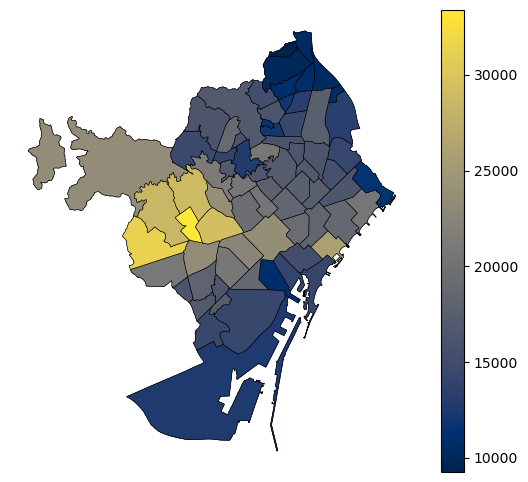

In [6]:
# --- CSV SELECTION ---

level = "Neighborhood"
year = 2022

# --- LOAD DATA ---

df = prepare_gdf(year)

# --- MAP ---

## Normalization values

vmin = df["rent_per_capita"].min() 
vmax = df["rent_per_capita"].max()

## Plotting

fig, ax = plt.subplots(1, 1, figsize = (7, 6))

plot_rent(year, ax)

mappable = plot_rent(year, ax)

## Colorbar for rent per capita

plt.colorbar(mappable, ax = ax)

## 2.2 - Rent Map Time Evolution

In [7]:
# # Time evolution of rent per capita per neighborhood

# years_all = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

# # Rent per capita per year per neighborhood

# rent_data = {year: prepare_gdf(year)[["Neighborhood", "rent_per_capita"]] for year in years_all}

# # Plot the time evolution of rent per capita for each neighborhood (not a map, just a line plot)

# import matplotlib.pyplot as plt
# for neighborhood in rent_data[2015]["Neighborhood"]:
#     rents = [rent_data[year].set_index("Neighborhood").loc[neighborhood, "rent_per_capita"] for year in years_all]
#     plt.plot(years_all, rents, label=neighborhood)

# plt.xlabel("Year")
# plt.ylabel("Rent per Capita")
# plt.title("Time Evolution of Rent per Capita per Neighborhood")
# plt.legend(loc="best", fontsize="small", ncol=2)
# plt.show()

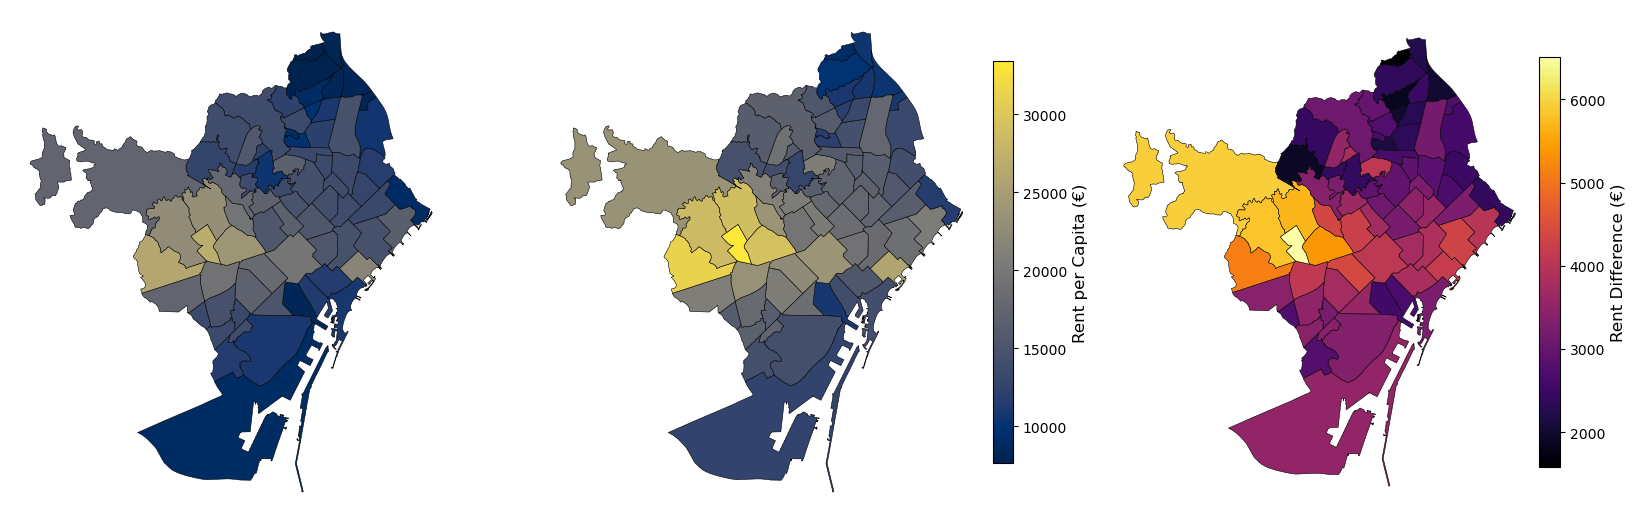

In [8]:
# --- CSV SELECTION ---

level = "Neighborhood"
years = [2015, 2022]

# --- LOAD DATA ---

df_years = {year: prepare_gdf(year) for year in years}  

# --- MAPS OF THE INITIAL AND FINAL YEAR ---

## We define a common color scale for both years

vmin = min(df_years[year]["rent_per_capita"].min() for year in years) # common vmin
vmax = max(df_years[year]["rent_per_capita"].max() for year in years) # common vmax

## Plotting the maps

fig, axes = plt.subplots(1, len(years)+1, figsize = (20, 10))
mappables = []
for ax, year in zip(axes, years):
    mappable = plot_rent(year, ax)
    mappables.append(mappable)  
    
## Colorbar for rent per capita

cbar = fig.colorbar(mappables[0], ax=axes[:-1], orientation = "vertical", fraction = 0.02, pad = 0.01)
cbar.set_label("Rent per Capita (€)", fontsize = 12)

# --- MAPS OF THE RENT DIFFERENCE BETWEEN THE YEARS ---

## Plotting the difference map

mappable_diff = plot_difference(axes[-1], years[0], years[1])

## Colorbar for rent difference

cbar_diff = fig.colorbar(mappable_diff, ax = axes[-1], orientation = "vertical", fraction = 0.045, pad = 0.01)
cbar_diff.set_label("Rent Difference (€)", fontsize = 12)
plt.show()
